# <b>Create Model For Training</b>
## Collecting and Cleaning Data
### 01_01 - Loading Data

In [4]:
# import libraries and set options, formating of floating-point numbers to 2 decimal places
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
# read the data from the json file
data = pd.read_json('otodom_data.json')
data.head()

,title,localization,price,price_per_m2,area,rooms,status,property_type,floor,balcony,heating_type
0,3-pokojowe mieszkanie 48m2 + loggia,"ul. Składowa, Krowodrza, Krowodrza, Kraków, ma...",770 018 zł,15 750 zł/m²,"48,89 m²",NaN,do wykończenia,pełna własność,1/5,None,None
1,"Bezpośrednio Kalwaryjska 78 - 42,92m2.","KALWARYJSKA NR 78, Krowodrza, Krowodrza, Krakó...",643 000 zł,14 981 zł/m²,"42,92 m²",NaN,do wykończenia,pełna własność,1/2,balkon,miejskie
2,"3 pokoje, duża loggia + 2 miejsca w garażu","ul. Wrocławska, Łobzów, Krowodrza, Kraków, mał...",985 000 zł,17 589 zł/m²,56 m²,NaN,do zamieszkania,pełna własność,1/6,balkon,miejskie
3,3-pokojowe mieszkanie 63m2 + balkon Bez Prowizji,"pl. Imbramowski, Prądnik Biały, Prądnik Biały,...",963 528 zł,15 200 zł/m²,"63,39 m²",NaN,do wykończenia,pełna własność,1/7,balkon,None
4,Kup Teraz - Zapłać w 10 ratach! NaGranicyKrakow,"Borek Fałęcki, Łagiewniki-Borek Fałęcki, Krakó...","695 296,45 zł",10 288 zł/m²,"67,58 m²",NaN,do zamieszkania,pełna własność,parter/1,"balkon, ogródek, taras",gazowe


### 01_02 - Check which colums may not be useful for analysis 

In [6]:
print(data.isna().sum()/len(data))

title           0.00
localization    0.00
price           0.09
price_per_m2    0.09
area            0.00
rooms           0.17
status          0.10
property_type   0.07
floor           0.01
balcony         0.21
heating_type    0.35
dtype: float64


In [7]:
print(data.value_counts('property_type'))

property_type
pełna własność                      144
spółdzielcze wł. prawo do lokalu      3
udział                                1
Name: count, dtype: int64


In [8]:
# cleaning data, removing columns: title and property_type, as they are not useful for analysis 
data.drop(['title', 'property_type'], axis=1, inplace=True)

In [9]:
# check for missing values in the "price" column in data
price_missing = data['price'].isna().sum()
price_missing/len(data)*100

9.375

In [10]:
# remove rows with missing values in the "price" column
# calculate the number of the rows in data after removing missing values
data.dropna(subset=['price'], inplace=True)
len(data)

145

### 01_03 - Cleaning Data

In [11]:
# cleaning data, creating lambda functions to remove unwanted characters from the columns and convert them to the appropriate data type
data['price'] = data['price'].apply(lambda x: x.replace(' ','').replace('zł', ''). replace(',','.')).astype(float)
data['price_per_m2'] = data['price_per_m2'].apply(lambda x: x.replace(' ','').replace('zł/m²', ''). replace(',','.')).astype(float)
data['area'] = data['area'].apply(lambda x: x.replace(' ','').replace('m²', ''). replace(',','.')).astype(float)
data['localization'] = data['localization'].apply(lambda x: x.split(',')[2] if x.startswith('ul') else x.split(',')[1])
data['floor'] = data['floor'].apply(lambda x: x.split('/')[0] if type(x) == str else x)
data['floor'] = data['floor'].replace('parter', 0)
data['floor'] = data['floor'].replace('suterena', -1)
data['floor'] = data['floor'].replace('poddasze', np.nan)
data['rooms'] = data['rooms'].replace('pierwotny', np.nan)

In [12]:
# calculate standard deviation and remove outliers from the "price" column
mean = data['price'].mean()
std = data['price'].std()
threshold = mean + 2 * std

prices_above_threshold = data[data['price'] > threshold]['price']
data = data[data['price'] <= threshold]

In [13]:
# categorize the "area" column into small, medium, large and huge
def categorize_area(area):
    if area <= 30:
        return 'small'
    elif area <= 60:
        return 'medium'
    elif area <= 90:
        return 'large'
    else: 
        return 'huge'

data['size'] = data['area'].apply(categorize_area)

In [14]:
# fill missing values in the "rooms" and "balcony" columns with the most common value in the "localization" group
data['rooms'] = data['rooms'].fillna(data['size'].map({'small': 1, 'medium': 2, 'large': 3, 'huge': 4}))
data['balcony'] = data.groupby('localization')['balcony'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)

In [15]:
# create new columns based on the "balcony" column
data['balkon'] = data['balcony'].apply(lambda x: 1 if isinstance(x, str) and 'balkon' in x else 0)
data['ogródek'] = data['balcony'].apply(lambda x: 1 if isinstance(x, str) and 'ogródek' in x else 0)
data['taras'] = data['balcony'].apply(lambda x: 1 if isinstance(x, str) and 'taras' in x else 0)

In [16]:
# fill missing values in the "heating_type" and "status" columns with the most common value
data['status'].fillna(data['status'].mode()[0], inplace=True)
data['heating_type'].fillna(data['heating_type'].mode()[0], inplace=True)
data['floor'].dropna(inplace=True)
data['rooms'].dropna(inplace=True)
data.drop(['price_per_m2', 'balcony'], axis=1, inplace=True)
data.dropna(inplace=True)

C:\Users\Komputer\AppData\Local\Temp\ipykernel_8112\3043946819.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['status'].fillna(data['status'].mode()[0], inplace=True)
C:\Users\Komputer\AppData\Local\Temp\ipykernel_8112\3043946819.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

### 01_04 - Visualisation of Average Price per Localization

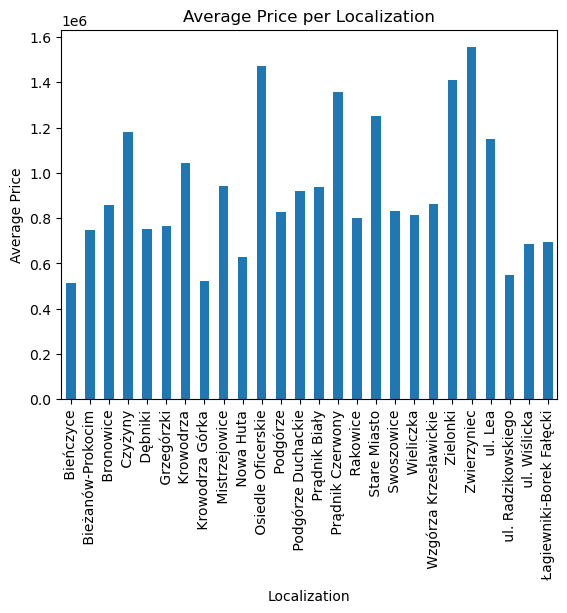

In [17]:
# calculate the average price per localization and plot the results 
average_price = data.groupby('localization')['price'].mean()
average_price.plot(kind='bar')
plt.xlabel('Localization')
plt.ylabel('Average Price')
plt.title('Average Price per Localization')
plt.xticks(rotation=90)
plt.show()

#### 01_05 - Save cleaned data to CSV file

In [18]:
# select only numeric columns from the data, save the cleaned data to a new csv file
data_numeric = data.select_dtypes(include=[np.number])
data.to_csv('cleaned_data.csv', index=False)

In [19]:
# calculate the number of values in the "floor" column
data.floor.value_counts()

floor
1     42
0     26
2     19
4     19
3     15
7      5
5      4
9      3
8      3
10     1
-1     1
6      1
Name: count, dtype: int64

#### 01_06 - Visualisation of Correlation Martix of a dataset

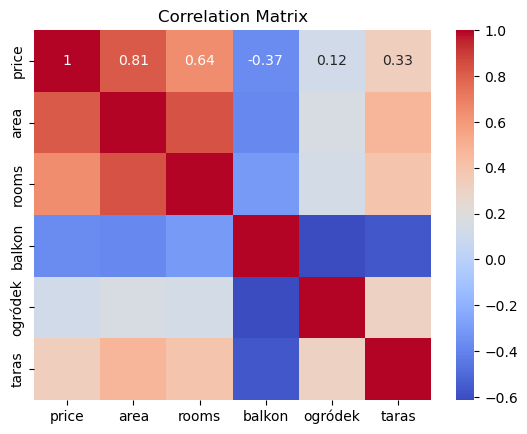

In [20]:
# plot Correlation Matrix using heatmap
sns.heatmap(data_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [21]:
# Convert categorical variables into dummy/indicator variables, dropping the first category to avoid multicollinearity
df_final = pd.get_dummies(data, drop_first=True)

In [29]:
df_final.head()

,price,area,rooms,balkon,ogródek,taras,localization_ Bieżanów-Prokocim,localization_ Bronowice,localization_ Czyżyny,localization_ Dębniki,...,floor_7,floor_8,floor_9,heating_type_gazowe,heating_type_inne,heating_type_kotłownia,heating_type_miejskie,size_large,size_medium,size_small
0,770018.00,48.89,2.00,1,0,0,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
1,643000.00,42.92,2.00,1,0,0,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2,985000.00,56.00,2.00,1,0,0,False,False,False,False,...,False,False,False,False,False,False,True,False,True,False
3,963528.00,63.39,3.00,1,0,0,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
4,695296.45,67.58,3.00,1,1,1,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False


In [22]:
df_final.columns

Index(['price', 'area', 'rooms', 'balkon', 'ogródek', 'taras',
       'localization_ Bieżanów-Prokocim', 'localization_ Bronowice',
       'localization_ Czyżyny', 'localization_ Dębniki',
       'localization_ Grzegórzki', 'localization_ Krowodrza',
       'localization_ Krowodrza Górka', 'localization_ Mistrzejowice',
       'localization_ Nowa Huta', 'localization_ Osiedle Oficerskie',
       'localization_ Podgórze', 'localization_ Podgórze Duchackie',
       'localization_ Prądnik Biały', 'localization_ Prądnik Czerwony',
       'localization_ Rakowice', 'localization_ Stare Miasto',
       'localization_ Swoszowice', 'localization_ Wieliczka',
       'localization_ Wzgórza Krzesławickie', 'localization_ Zielonki',
       'localization_ Zwierzyniec', 'localization_ ul. Lea',
       'localization_ ul. Radzikowskiego', 'localization_ ul. Wiślicka',
       'localization_ Łagiewniki-Borek Fałęcki', 'status_do wykończenia',
       'status_do zamieszkania', 'floor_0', 'floor_1', 'floor_

In [31]:
# Drop the 'price' column from df_final to create the feature set X
# Extract the 'price' column from df_final to create the target variable y
X = df_final.drop('price', axis=1)
y = df_final['price']

In [24]:
# Import the train_test_split function from scikit-learn to split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Import the LinearRegression model from scikit-learn
from sklearn.linear_model import LinearRegression

# Import metrics for evaluating the model's performance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Initialize the LinearRegression model
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Evaluate the model's performance on the test data
score = model.score(X_test, y_test)

# Predict the target variable for the test data
y_pred = model.predict(X_test)

# Output the predicted values
y_pred

array([ 984030.52906499, 1146699.49820676,  687158.87545026,
        947929.09208411,  673061.91924037,  638090.63324194,
        143813.54365293,  823399.67866757,  657800.87091033,
       1669549.3245976 ,  985876.70804887,  755977.48380842,
        629145.64652046,  701971.24359094, 1694429.16614327,
       1192007.91205402,  880454.06015561, 1023331.08234571,
        877962.70424419, 1607924.20310584, 1054757.80355031,
       1122182.28220438,  698331.27678167,  654363.02955184,
       1120724.78657076,  743311.88607304,  936031.46032009,
        893585.96930836])

In [26]:
# Calculate the Mean Absolute Error (MAE) between the actual and predicted values
mae = mean_absolute_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE) between the actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Print the R^2 score of the model
print(f'R^2: {score}')

# Print the Mean Absolute Error (MAE)
print(f'MAE: {mae}')

# Print the Root Mean Squared Error (RMSE)
print(f'RMSE: {rmse}')

R^2: 0.6816851144613718
MAE: 134498.65915017927
RMSE: 192574.15089343028


#### 01_07 - Save trained model

In [27]:
import pickle

# Save the trained model object to a file named 'model.pkl' using pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)